# Multilinear Discriminant Analysis

This short notebook walks through a basic implementation of **Multilinear Discriminant Analysis** [1,2], using the **Tensorly** [3] library for Python, and provides a simple demo of using the learnt low-dimensional tensor subspace to perform face recognition with 94% accuracy.

Included is the following:

1. [MDA at a high-level](#MDA-at-a-high-level)
2. [Forming the train- and test-set tensors](#forming-the-train--and-test-set-image-tensors)
3. [Computing the mean tensors](#computing-the-mean-tensors)
4. [The *scatter ratio criterion* for projection matrix $n$](#The-scatter-ratio-criterion-for-projection-matrix-$n$)
5. [Computing the between- and within-class scatter matrices](#computing-the-between--and-within-class-scatter-matrices)
6. [Solving for projection matrix $\mathbf{U}_n$](#Solving-for-projection-matrix-$\mathbf{U}_n$)
7. [Solving for all projection matrices via $k$-mode optimization](#Solving-for-all-projection-matrices-via-$k$-mode-optimization)
8. [Classification experiments vs LDA/raw pixel data](#classification-accuracy-vs-LDA/raw-pixels)

### download the images
- please first download the following aligned and cropped version of the **YaleB-extended** dataset [4,5] by clicking on the following link [http://vision.ucsd.edu/extyaleb/CroppedYaleBZip/CroppedYale.zip](http://vision.ucsd.edu/extyaleb/CroppedYaleBZip/CroppedYale.zip)
- once downloaded, upzip to a folder named `./CroppedYale/` in the project's root directory

---

[1]: S. Yan, D. Xu, Q. Yang, L. Zhang, X. Tang and H. Zhang, "Multilinear Discriminant Analysis for Face Recognition," in IEEE Transactions on Image Processing, vol. 16, no. 1, pp. 212-220, Jan. 2007, doi: 10.1109/TIP.2006.884929.

[2]: Q. Li and D. Schonfeld, "Multilinear Discriminant Analysis for Higher-Order Tensor Data Classification," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 36, no. 12, pp. 2524-2537, 1 Dec. 2014, doi: 10.1109/TPAMI.2014.2342214.

[3]: Jean Kossaifi, Yannis Panagakis, Anima Anandkumar and Maja Pantic, TensorLy: Tensor Learning in Python, https://arxiv.org/abs/1610.09555.

[4]: Kuang-Chih Lee, J. Ho and D. J. Kriegman, "Acquiring linear subspaces for face recognition under variable lighting," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 27, no. 5, pp. 684-698, May 2005, doi: 10.1109/TPAMI.2005.92.

[5]: A. S. Georghiades, P. N. Belhumeur and D. J. Kriegman, "From few to many: illumination cone models for face recognition under variable lighting and pose," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 23, no. 6, pp. 643-660, June 2001, doi: 10.1109/34.927464.


## MDA at a high-level

One of the downsides to principal component analysis (PCA)-based approaches to dimensionality reduction is that the class labels are not taken into account, and hence discriminative information may be lost in the low-dimensional representation [6]. (Fisher) *Linear discriminant analysis* (LDA) tackles some of these issues with an objective designed to produce class-separability in the projected space. In *Multilinear Discriminant Analysis* (MDA), rather than projecting the data onto one subspace like with standard LDA, we learn a subspace for each of the $K$ modes of our $K$th order data tensor $\mathcal{X}\in\mathbb{R}^{m_1\times\ m_2\times\cdots\times m_K}$.

In MDA the goal is to maximise the separation between the class means in the tensor subspace, and maximise the intraclass overlap [1,2]. Following the idea of the *Fisher criterion* [7], we wish to define an objective that maximises the **between-class** scatter, and minimises the **within-class** scatter. For each of the $K$ modes, we seek to learn a projection matrix $\mathbf{U}_k\in\mathbb{R}^{m_k \times m_k^*}$, where $m_k* < m_k$ is the dimensionality of the lower-dimensional subspace for mode $k$. This gives rise to the projected lower-dimensional tensor, which we can use for downstream tasks, such as identity recognition

$$\mathcal{Z} = \mathcal{X} \times_1 \mathbf{U}^\top_1  \times_2 \mathbf{U}^\top_2 \cdots \times_K \mathbf{U}^\top_K \in\mathbb{R}^{m_1^*\times\cdots\times m_K^*}.$$

Intuitively, we want the projected data points to be well-separated by class label, and for the intraclass-overlap to be as large as possible.

---

[1]: S. Yan, D. Xu, Q. Yang, L. Zhang, X. Tang and H. Zhang, "Multilinear Discriminant Analysis for Face Recognition," in IEEE Transactions on Image Processing, vol. 16, no. 1, pp. 212-220, Jan. 2007, doi: 10.1109/TIP.2006.884929.

[2]: Q. Li and D. Schonfeld, "Multilinear Discriminant Analysis for Higher-Order Tensor Data Classification," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 36, no. 12, pp. 2524-2537, 1 Dec. 2014, doi: 10.1109/TPAMI.2014.2342214.

[6]: Welling, Max. Fisher linear discriminant analysis. Technical report, University of Toronto, Toronto, Ontario,
Canada, 2005.

[7]: Bishop, C. M. (2007). Pattern Recognition and Machine Learning (Information Science and Statistics). Springer. ISBN: 0387310738

In [1]:
from PIL import Image
import glob
from matplotlib import pyplot as plt
from skimage import data
from scipy.linalg import eigh, svd
from sklearn import preprocessing

import tensorly as tl
import numpy as np
import itertools
flatten = itertools.chain.from_iterable

tl.set_backend('numpy')
np.random.seed(1234)

## forming the train- and test-set image tensors

Our training samples are denoted as $K$th order tensors, $\mathcal{X}_{ij}\in\mathbb{R}^{m_1\times\ m_2\times\cdots\times m_K}$, where the subscripts denote that the training sample $\mathcal{X}_{ij}$ is the $j$th example of the total of $n_i$ examples for class $i$. We have a total number of $c$ mututally exclusive class labels.

In our case, our image tensors are 2nd order, but precisely the same approach applies to higher-order tensors (e.g. image tensors of 3rd-order, with a 'colour' channel). Each data point is of size $64\times64$, and our number of unique classes (identities) is $c=38$.

We first load in the YaleB dataset in a standard fashion, take 80% for the training set, and then form tensorly tensors from them as follows

In [2]:
files = tl.tensor([x for x in glob.glob('./CroppedYale/*/*') if '.pgm' in x and 'Ambient' not in x])

# get test and train splits
num_data = len(files)
num_train = round(num_data * 0.8)

X_train, X_test = [], []
y_train, y_test = [], []

idx = np.random.permutation(num_data)
tr_idx, te_idx = idx[:num_train], idx[num_train:]

files_train, files_test = files[tr_idx], files[te_idx]

img_size = 64

# some ids (e.g. 14) are missing so index by their string
file_ids = [x.split('/')[2][-2:] for x in files]
unique_ids = list(set(file_ids))  # store unique identity labels

people_idx = [[] for _ in unique_ids]  # store the indices of training data that belong to each identity

# form the train data tensor
for i, f in enumerate(files_train):
    # store the person's id label
    person = f.split('/')[2][-2:]
    y_train += [unique_ids.index(person)]
    
    people_idx[unique_ids.index(person)] += [i]
        
    X_train += [np.array(Image.open(f).convert('L').resize((img_size, img_size)))]
    
# form the test data tensor
for i, f in enumerate(files_test):
    person =  f.split('/')[2][-2:]
    y_test += [unique_ids.index(person)]

    X_test += [np.array(Image.open(f).convert('L').resize((img_size, img_size)))]

X_train = tl.tensor(X_train)
X_test = tl.tensor(X_test)

y_train = tl.tensor(y_train)
y_test = tl.tensor(y_test)

print('---')
print('Shape of training set is: {}'.format(X_train.shape))
print('Shape of test set is: {}'.format(X_test.shape))

---
Shape of training set is: (1946, 64, 64)
Shape of test set is: (486, 64, 64)


## computing the mean tensors

For the computation of the scatter matrices, we will need a global mean tensor $\mathcal{M}$ (the higher-order analogue of our mean vector $\mathbf{m}_i$ in the standard LDA setting), and a set of class-specific mean tensors $\mathcal{M}_i$ for $i=1,\dots c$.

The class-specific mean tensors are computed as

$$\mathcal{M}_i= \frac{1}{n_i} \sum_{j=1}^{n_i} \mathcal{X}_{ij},$$

and the global mean tensor as

$$\mathcal{M}= \frac{1}{N} \sum_{i=1}^c \sum_{j=1}^{n_i} \mathcal{X}_{ij}.$$

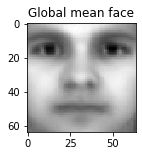

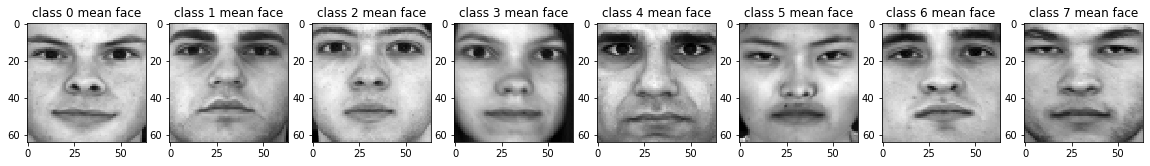

In [3]:
# global and class-specific mean tensors
global_mean = tl.mean(X_train, axis=0)
class_means = []

# compute the mean tensor for each identity
for person_idx in people_idx:
    class_means += [tl.mean(X_train[person_idx], axis=0)]
    
plt.figure(figsize=(2, 2))
plt.imshow(global_mean, cmap='gray')
plt.title('Global mean face')

fig, axs = plt.subplots(1, 8, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.imshow(class_means[i], cmap='gray')
    ax.set_title('class {} mean face'.format(i))

## The *scatter ratio criterion* for projection matrix $n$

Following [2], we arrive at the so-called **scatter ratio objective function** (as a natural higher-order extension of the Fisher criterion) for each mode $n$ as

$$ \begin{align}
J(\mathbf{U}_n)
    &= \frac{ \sum_{i=1}^c n_i || \left( \mathcal{M}_i - \mathcal{M} \right) \times_1 \mathbf{U}^\top_1 \cdots \times_K \mathbf{U}^\top_K ||^2_F }{ \sum_{i=1}^c \sum_{j=1}^{n_i}  || \left( \mathcal{X}_{ij} - \mathcal{M}_i \right) \times_1 \mathbf{U}^\top_1 \cdots \times_K \mathbf{U}^\top_K ||^2_F } \\
    &= \frac{\text{tr} \left\{ \mathbf{U}^\top \mathbf{B}_n^{\bar{n}}\mathbf{U}_n \right\} }{ \text{tr} \left\{ \mathbf{U}^\top \mathbf{W}_n^{\bar{n}}\mathbf{U}_n \right\} }
\end{align},$$

where Li *et al.* [2] define $\mathbf{B}_n^{\bar{n}}$ and $\mathbf{W}_n^{\bar{n}}$ as the mode-$n$ between- and within-class scatter matrices in the partially projected tensor subspace, along all modes except $n$. Li *et al.* write these higher-order mode-$n$ scatter matrices analogues as

$$
\mathbf{B}_n^{\bar{n}}
    = \sum_{i=1}^c n_i \left[ \left(\mathcal{M}_i - \mathcal{M}\right) \prod_{\substack{k=1 \\ k\neq n}}^K \times_k \mathbf{U}^\top_k \right]_{(n)}
    \left[ \left(\mathcal{M}_i - \mathcal{M}\right) \prod_{\substack{k=1 \\ k\neq n}}^K \times_k \mathbf{U}^\top_k \right]_{(n)}^\top,
$$

for the **between-class scatter**, and

$$
\mathbf{W}_n^{\bar{n}}
    = \sum_{i=1}^c \sum_{j=1}^{n_i} \left[ \left(\mathcal{X}_{ij} - \mathcal{M}_i\right) \prod_{\substack{k=1 \\ k\neq n}}^K \times_k \mathbf{U}^\top_k \right]_{(n)}
    \left[ \left(\mathcal{X}_{ij} - \mathcal{M}_i\right) \prod_{\substack{k=1 \\ k\neq n}}^K \times_k \mathbf{U}^\top_k \right]_{(n)}^\top,
$$

for the **within-class scatter**, with $\mathbf{X}_{(n)}$ denoting the *mode-$n$ unfolding* of tensor $\mathcal{X}$.

This mode-$n$ product over all modes but $k$ can be computed in **tensorly** with the `tl.tenalg.multi_mode_dot` function, by supplying the `skip=k` argument as follows below.

We first define the list of projection matrices for each mode $\mathbf{U}_k$, initialising them as a tensor of all ones

In [4]:
rank = 8
factors = [tl.ones((dim, rank)) for i, dim in enumerate(list(X_train.shape)[1:])]

We can then compute the term
$\left(\mathcal{M}_i - \mathcal{M}\right) \prod_{\substack{k=0 \\ k\neq n}}^K \times_k \mathbf{U}^\top_k$ with **Tensorly** very straight-forwardly with one line of code as

In [5]:
M = class_means[0] - global_mean
# mode-n product of M with every matrix (but the current kth) in factors
proj_but_k = tl.tenalg.multi_mode_dot(M, factors, transpose=True, skip=1)

## computing the between- and within-class scatter matrices

With these quantities computed above, we can now form both the between- and within-class scatter matrices for mode-$n$ by simply summing jointly over the class labels (for the former) and datapoints of each class label (for the later):

In [6]:
# ---------
# Compute the mode k-unfolded within- and between-class scatter matrices
# ---------

num_classes = len(class_means)
num_modes = len(X_train.shape) - 1
num_each_class = [len(p) for p in people_idx]

def compute_mode_k_scatters(mode, factors):
    B_scat = tl.zeros(X_train.shape[1:])
    W_scat = tl.zeros(X_train.shape[1:])

    for c in range(num_classes):
        M = class_means[c] - global_mean
        proj_but_k = tl.unfold(tl.tenalg.multi_mode_dot(M, factors, transpose=True, skip=mode), mode)
        B_scat += num_each_class[c] * tl.dot(proj_but_k, proj_but_k.T)

        # inner loop for within-class computation
        for j in range(num_each_class[c]):
            # subtract mean for person c from jth image of cth person
            M = X_train[people_idx[c][j]] - class_means[c]

            proj_but_k = tl.unfold(tl.tenalg.multi_mode_dot(M, factors, transpose=True, skip=mode), mode)
            W_scat += tl.dot(proj_but_k, proj_but_k.T)
            
    return B_scat, W_scat

B_scat, W_scat = compute_mode_k_scatters(0, factors)

## Solving for projection matrix $\mathbf{U}_n$

We assume we have known the projection matrices $\mathbf{U}_k$, for $k=1,\dots,n-1,n+1,\dots,K$ (either by us having already computed them (if $k<n$) or via their initial state as $\mathbf{1}$-matrices). We can then solve for projection matrix $\mathbf{U}_n$ in the **scatter ratio objective** $\mathbf{U}_n^*=\arg\max_{\mathbf{U}_n} J(\mathbf{U}_n)$ via the solution to the generalised eigenproblem [1,2,6]. In the likely case when the mode-$n$ within-class scatter matrix $\mathbf{W}_n^{\bar{n}}$ is nonsingular, this reduces to a standard eigenproblem.

Computing the top `rank` number of eigenvectors for $\left(\mathbf{W}_n^{\bar{n}}\right)^{-1}\mathbf{B}_n^{\bar{n}}$ with **Tensorly** gives us the solution for the mode-$n$ projection matrix.

In [7]:
# solve for projection matrix for mode k as top `rank` # of eigenvectors
U, _, _ = tl.partial_svd(tl.dot(tl.tensor(np.linalg.inv(W_scat)),  B_scat), n_eigenvecs=rank)
factors[0] = U

## Solving for all projection matrices via $k$-mode optimization

To solve for *all* projection matrices, we need to employ an iterative scheme, due to the fact that the solution projection matrix for a given mode depends on projection matrices from all the other modes. MDA [3] first initializes all projection matrices as $\mathbf{1}$-matrices, and employs an iterative scheme to solve for each projection matrix at a time.

### classification using the low-dimensional tensors

To test how well our low-dimensional embeddings preserve class-discriminative information at each iteration, we employ a simple 1-NN classification approach to classify the test set. For a new test data point $\hat{\mathcal{X}}$, we first project it onto the lower dimensional subspaces as $\hat{\mathcal{Z}} = \hat{\mathcal{X}} \times_1 \mathbf{U}^\top_1 \cdots \times_K \mathbf{U}^\top_K$, and then classify it using the simple nearest neighbour approach

$$c_i =\arg\min_i ||\mathcal{Z}_i - \hat{\mathcal{Z}} ||$$

in **Tensorly**, this can be achieved using the `tl.tenalg.multi_mode_dot` method along `modes=[1, 2]`  using the learnt mode projection matrices at time step-$t$, and `tl.norm` to measure the distance between points in the tensor subspace:

In [8]:
def one_NN(Z_train, Z_test, y_train, y_test):
    y_preds = []
    for z_test in Z_test:
        smallest_dist = np.infty
        prediction = -1

        for z, label in zip(Z_train, y_train):
            dist = tl.norm(z - z_test).item()
            if dist < smallest_dist:
                smallest_dist = dist
                prediction = label.item()

        y_preds += [int(prediction)]

    acc = (y_preds==tl.to_numpy(y_test)).mean()
    return acc

In [9]:
total_iters = 10

# size of desired low-dim subspace (shared across all modes)
rank = 16
rank = num_classes - 1

accs = []
its = []

# initialise the factor matrices as 1 matrices
factors = [tl.ones((dim, rank)) for i, dim in enumerate(list(X_train.shape)[1:])]

for t in range(1, total_iters + 1):
    for k in range(num_modes):
        B_scat, W_scat = compute_mode_k_scatters(k, factors)
        U, _, _ = tl.partial_svd(tl.dot(tl.tensor(np.linalg.inv(W_scat)),  B_scat), n_eigenvecs=rank)
        factors[k] = U
        
        error = tl.norm(tl.dot(factors[k], factors[k].T) - tl.eye(X_train.shape[1+k]))
        
    if t % 10 == 0:
        print('Computing accuracy using projection matrices at iteration {}...'.format(t))
        
    Z_train = tl.tenalg.multi_mode_dot(X_train, factors, modes=[1, 2], transpose=True)
    Z_test = tl.tenalg.multi_mode_dot(X_test, factors, modes=[1, 2], transpose=True)
    accs += [one_NN(Z_train, Z_test, y_train, y_test)]
    its += [t]
            
print('...done')

Computing accuracy using projection matrices at iteration 10...
...done


## classification accuracy vs LDA/raw pixels

Let's also run the identity classification on the embeddings attained via (i) LDA on the vectorized pixels and (ii) the raw pixel values themselves to see how MDA compares:

/home/james/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


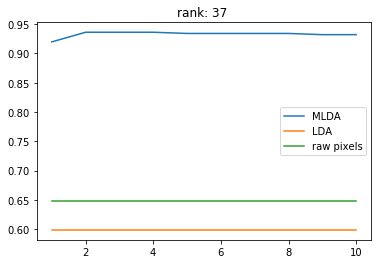

best accuracy of 0.9362139917695473 at iteration 2: 
lda:  0.5987654320987654
raw pixels:  0.6481481481481481


In [10]:
plt.plot(its, accs, label='MLDA')
plt.title('rank: {} '.format(rank))

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis(n_components=num_classes-1)
#clf = LinearDiscriminantAnalysis(n_components=16)

clf.fit(X_train.reshape([-1, img_size**2]), y_train)

Z_train = clf.transform(X_train.reshape([-1, img_size**2]))
Z_test = clf.transform(X_test.reshape([-1, img_size**2]))

lda_acc = one_NN(tl.tensor(Z_train), tl.tensor(Z_test), y_train, y_test)
plt.plot(its, [lda_acc] * len(its), label='LDA')

raw_acc = one_NN(X_train, X_test, y_train, y_test)
plt.plot(its, [raw_acc] * len(its), label='raw pixels')
plt.legend()
plt.show()

print('best accuracy of {} at iteration {}: '.format(np.max(np.array(accs)), its[np.argmax(np.array(accs))] ))
print('lda: ', lda_acc)
print('raw pixels: ', raw_acc)